In [3]:
file_prefix <- "ch18.3"
reuse_fit <- T
source("preset.R")

In [9]:
input_file <- "data/Guber1999data.csv"
N_RAND = 12
x_org_names <- c("Spend", "PrcntTake")
y_name <- "SATT"
x_rnd_names <- map_chr(1:N_RAND, ~c("xrand_" %+% .x))
x_names <- c(x_org_names, x_rnd_names)
coeff_names <- map_chr(1:length(x_names), ~"beta_" %+% .x)

# data

In [16]:
data <- read_csv(input_file)
rnd_tbl <- matrix(rnorm(nrow(data) * N_RAND), ncol = N_RAND)
colnames(rnd_tbl) <- x_rnd_names
data <- bind_cols(data, as_tibble(rnd_tbl))

Parsed with column specification:
cols(
  State = col_character(),
  Spend = col_double(),
  StuTeaRat = col_double(),
  Salary = col_double(),
  PrcntTake = col_double(),
  SATV = col_double(),
  SATM = col_double(),
  SATT = col_double()
)



In [17]:
stan_data <- list(
  N = nrow(data), 
  K = length(x_names), 
  x = data %>% select(x_names) %>% mutate_if(is.numeric, standardize) %>% as.matrix(),
  y = data[[y_name]] %>% standardize()
)

# fit

In [18]:
fit <- stan(file = "model/ch18.3.stan", data = stan_data, seed = 123, 
            pars = c("nu_minus1"), include = F, 
            chains = 4, warmup = 300, iter = 10000, thin = 2) 

Warning message:
“There were 116 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [19]:
save(fit, file = save_file_name("fit"))
load(file = save_file_name("fit"))

In [20]:
fit

Inference for Stan model: ch18.
4 chains, each with iter=10000; warmup=300; thin=2; 
post-warmup draws per chain=4850, total post-warmup draws=19400.

            mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
sigma_beta  0.09    0.00  0.04  0.04  0.06  0.09  0.12   0.20 12294    1
alpha       0.00    0.00  0.06 -0.12 -0.04  0.00  0.04   0.12 18327    1
beta[1]     0.13    0.00  0.08 -0.01  0.08  0.13  0.19   0.29 15882    1
beta[2]    -0.92    0.00  0.09 -1.10 -0.98 -0.92 -0.86  -0.75 17012    1
beta[3]    -0.10    0.00  0.07 -0.24 -0.15 -0.10 -0.05   0.02 16481    1
beta[4]    -0.06    0.00  0.06 -0.18 -0.10 -0.06 -0.02   0.04 15882    1
beta[5]    -0.07    0.00  0.07 -0.21 -0.12 -0.07 -0.03   0.04 15911    1
beta[6]     0.05    0.00  0.06 -0.06  0.01  0.04  0.09   0.17 18402    1
beta[7]    -0.01    0.00  0.06 -0.13 -0.05 -0.01  0.02   0.09 17669    1
beta[8]    -0.03    0.00  0.05 -0.14 -0.06 -0.02  0.01   0.08 17770    1
beta[9]     0.00    0.00  0.05 -0.10 -0.03  0.

In [ ]:
#ggs_traceplot(ggs(fit, inc_warmup = F))

# result

In [21]:
res <- fit_to_tibble(fit) %>% 
  mutate(log_nu = log10(nu)) %>% 
  add_linear_regression_Rsq(data, coeff_names, x_names, y_name) 

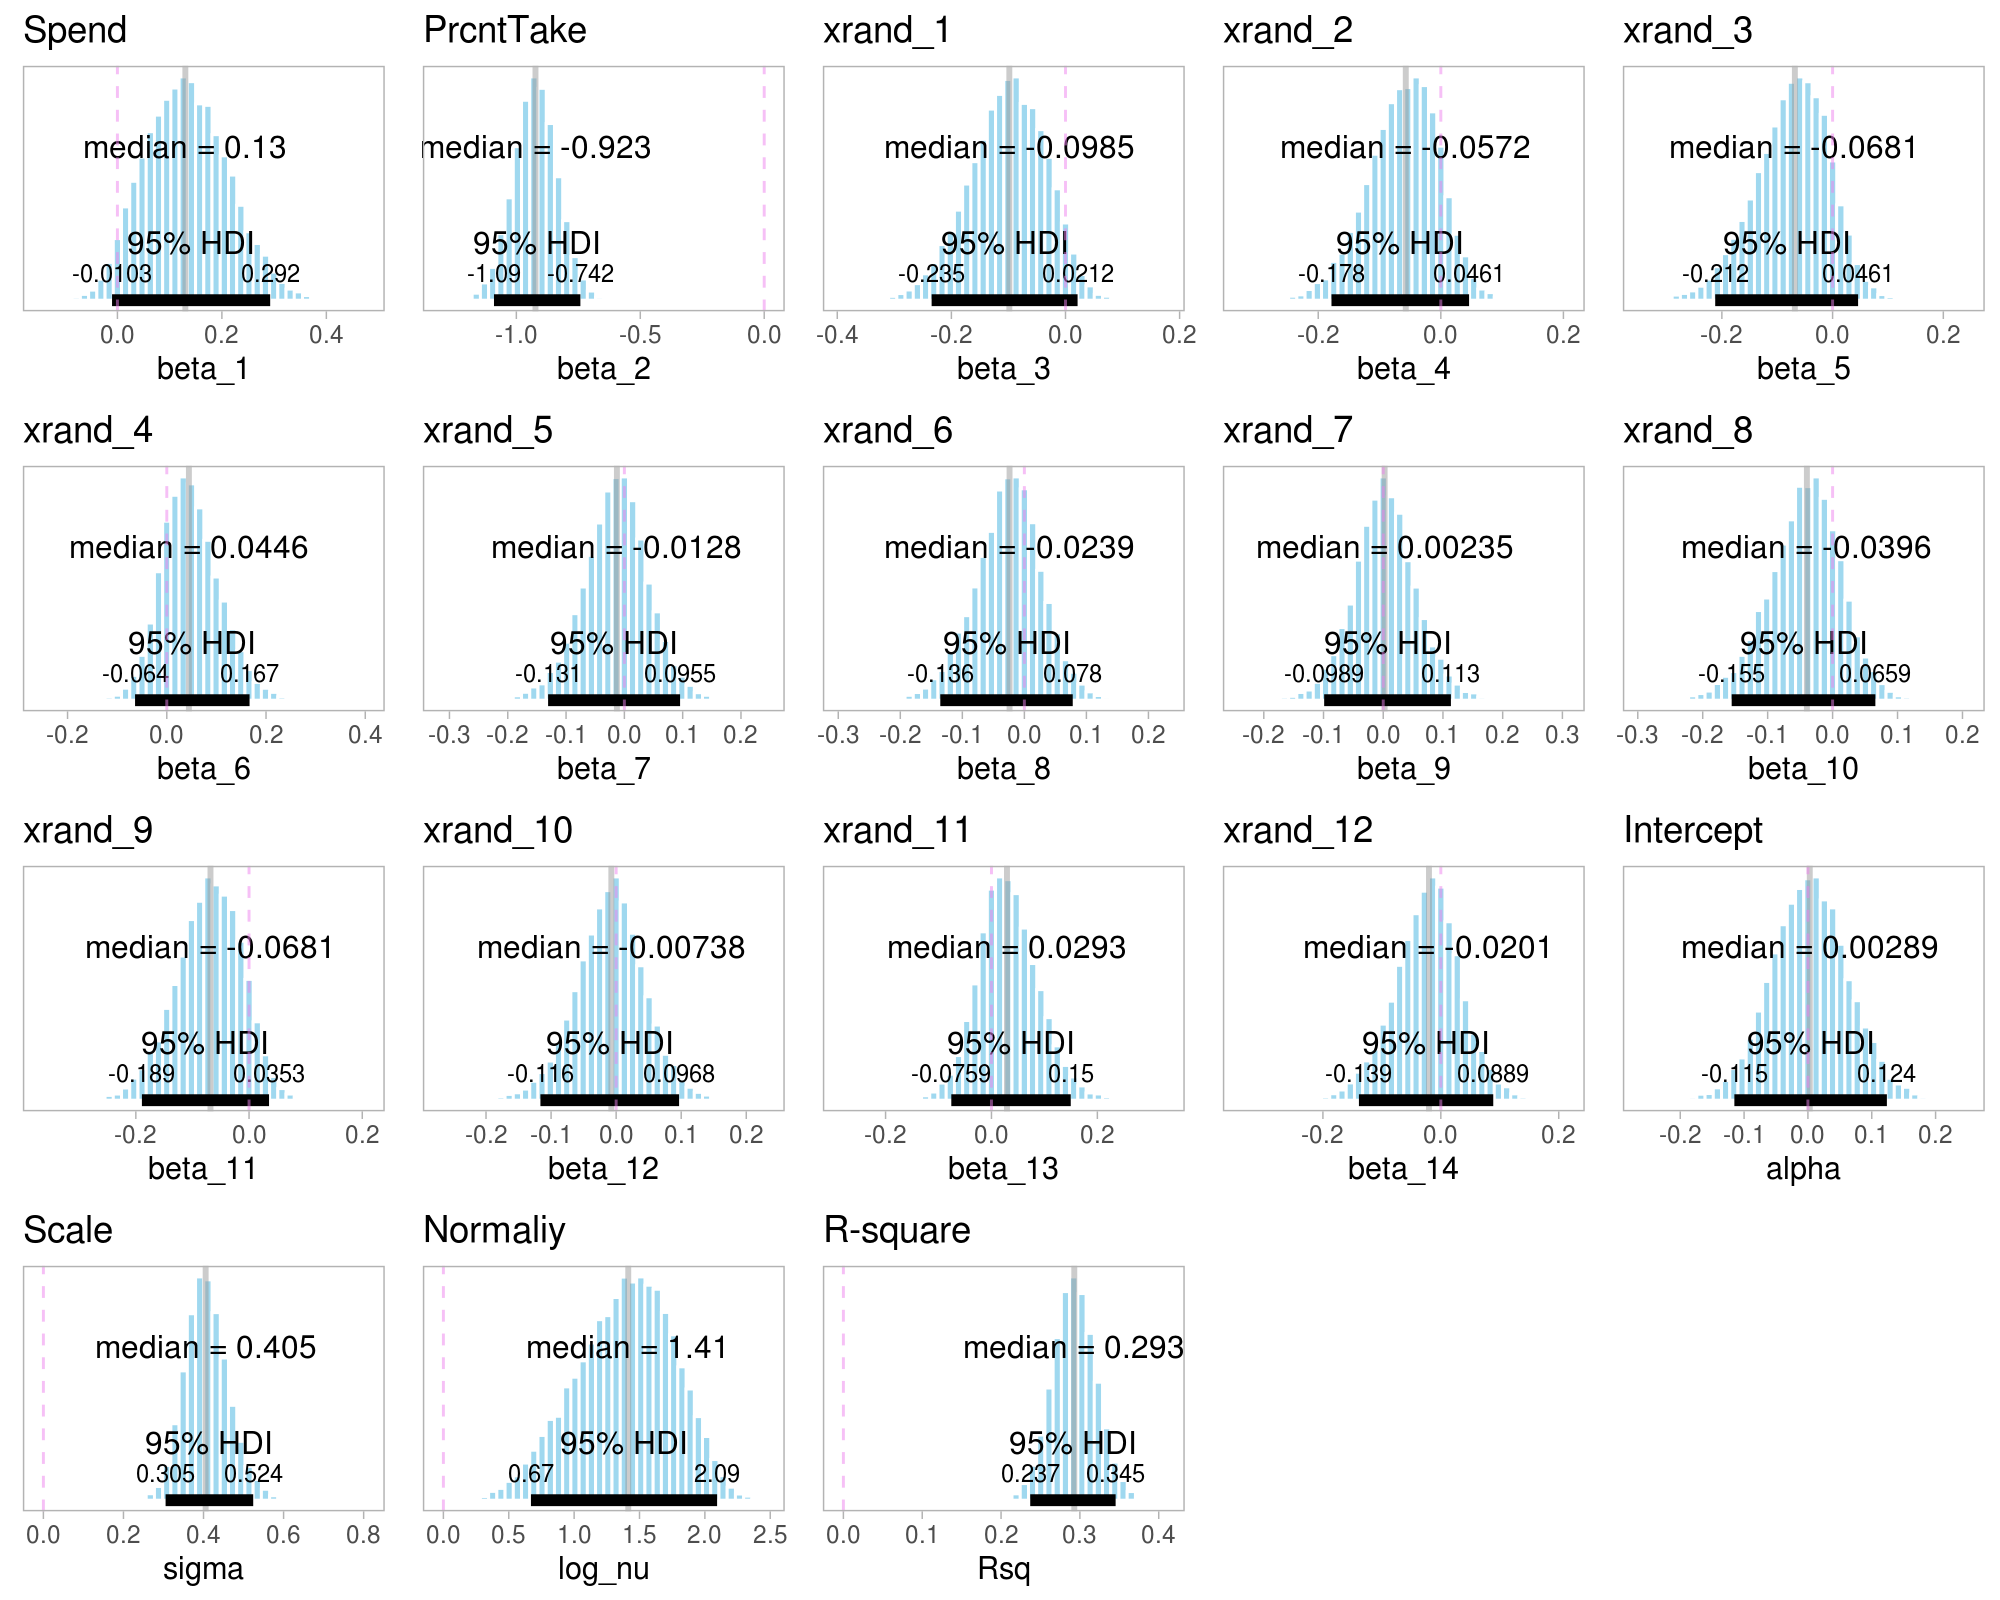

In [23]:
set_plot_size(10, 8)
# note: coeff of normalized input data
grid.arrange(
  grobs = map2(
    c(coeff_names, "alpha", "sigma", "log_nu", "Rsq"), 
    c(x_names, "Intercept", "Scale", "Normaliy", "R-square"), 
    ~plot_post(res, param_name = .x, title = .y, comp_val = 0)), 
  ncol = 5
) 